# Cavern storage capacity with net-to-gross

In [1]:
import os

import cartopy.crs as ccrs
import contextily as cx
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib import ticker
from matplotlib.lines import Line2D
from matplotlib_scalebar.scalebar import ScaleBar
import numpy as np

from h2ss import capacity as cap
from h2ss import data as rd
from h2ss import functions as fns
from h2ss import compare

In [2]:
# basemap cache directory
cx.set_cache_dir(os.path.join("data", "basemaps"))

## Halite data

In [3]:
ds, extent = rd.kish_basin_data_depth_adjusted(
    dat_path=os.path.join("data", "kish-basin"),
    bathymetry_path=os.path.join("data", "bathymetry"),
)

In [4]:
xmin, ymin, xmax, ymax = extent.total_bounds

## Constraints

In [5]:
# exploration wells
_, wells_b = fns.constraint_exploration_well(
    data_path=os.path.join(
        "data",
        "exploration-wells",
        "Exploration_Wells_Irish_Offshore.shapezip.zip",
    )
)

# wind farms
wind_farms = fns.constraint_wind_farm(
    data_path=os.path.join(
        "data", "wind-farms", "wind-farms-foreshore-process.zip"
    ),
    dat_extent=extent,
)

# frequent shipping routes
_, shipping_b = fns.constraint_shipping_routes(
    data_path=os.path.join(
        "data", "shipping", "shipping_frequently_used_routes.zip"
    ),
    dat_extent=extent,
)

# shipwrecks
_, shipwrecks_b = fns.constraint_shipwrecks(
    data_path=os.path.join(
        "data", "shipwrecks", "IE_GSI_MI_Shipwrecks_IE_Waters_WGS84_LAT.zip"
    ),
    dat_extent=extent,
)

# subsea cables
_, cables_b = fns.constraint_subsea_cables(
    data_path=os.path.join("data", "subsea-cables", "KIS-ORCA.gpkg")
)

## HYSS case

In [6]:
CAVERN_DIAMETER = 85
SEPARATION = 4 * CAVERN_DIAMETER
PILLAR_WIDTH = 3 * CAVERN_DIAMETER

In [7]:
# distance from salt formation edge
edge_buffer = fns.constraint_halite_edge(dat_xr=ds, buffer=PILLAR_WIDTH)

## Zones of interest

In [8]:
zones, zds = fns.zones_of_interest(
    dat_xr=ds, constraints={"net_height": 120, "min_depth": 500, "max_depth": 2000},
)

## Generate caverns

In [9]:
caverns = fns.generate_caverns_hexagonal_grid(
    zones_df=zones,
    dat_extent=extent,
    diameter=CAVERN_DIAMETER,
    separation=SEPARATION,
)

In [10]:
caverns = fns.cavern_dataframe(
    dat_zone=zds,
    cavern_df=caverns,
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [11]:
# label caverns by depth and heights
caverns = fns.label_caverns(
    cavern_df=caverns,
    heights=[120],
    depths={"min": 500, "min_opt": 1000, "max_opt": 1500, "max": 2000},
)

In [12]:
caverns, _ = fns.generate_caverns_with_constraints(
    cavern_df=caverns,
    exclusions={
        "wells": wells_b,
        "wind_farms": wind_farms,
        "shipwrecks": shipwrecks_b,
        "shipping": shipping_b,
        "cables": cables_b,
        "edge": edge_buffer,
    },
)

Without constraints...
Number of potential caverns: 568
------------------------------------------------------------
Excluding salt formation edges...
Number of potential caverns: 539
------------------------------------------------------------
Exclude shipping...
Number of potential caverns: 261
Caverns excluded: 51.58%
------------------------------------------------------------
Exclude wind farms...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude cables...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude wells...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------
Exclude shipwrecks...
Number of potential caverns: 218
Caverns excluded: 59.55%
------------------------------------------------------------


## Capacity

### Cavern volume

In [13]:
caverns["cavern_total_volume"] = cap.cavern_volume(
    height=caverns["cavern_height"], diameter=CAVERN_DIAMETER
)
caverns["cavern_volume"] = cap.corrected_cavern_volume(
    v_cavern=caverns["cavern_total_volume"], f_if=0
)

### Mid-point temperature

In [14]:
caverns["t_mid_point"] = cap.temperature_cavern_mid_point(
    height=caverns["cavern_height"], depth_top=caverns["cavern_depth"]
)

### Operating pressure

In [15]:
(
    caverns["p_operating_min"],
    caverns["p_operating_max"],
) = cap.pressure_operating(thickness_overburden=caverns["TopDepthSeabed"], depth_water=-caverns["Bathymetry"])

### Hydrogen gas density

In [16]:
caverns["rho_min"], caverns["rho_max"] = cap.density_hydrogen_gas(
    p_operating_min=caverns["p_operating_min"],
    p_operating_max=caverns["p_operating_max"],
    t_mid_point=caverns["t_mid_point"],
)

### Working mass of hydrogen

In [17]:
(
    caverns["working_mass"],
    caverns["mass_operating_min"],
    caverns["mass_operating_max"],
) = cap.mass_hydrogen_working(
    rho_h2_min=caverns["rho_min"],
    rho_h2_max=caverns["rho_max"],
    v_cavern=caverns["cavern_volume"],
)

### Energy storage capacity in GWh

In [18]:
caverns["capacity"] = cap.energy_storage_capacity(
    m_working=caverns["working_mass"]
)

## Stats

In [19]:
# proportion of working gas to total gas
caverns["working_mass_pct"] = caverns["working_mass"] / (
    caverns["working_mass"] + caverns["mass_operating_min"]
)

In [20]:
caverns.drop(columns=["x", "y", "BaseDepth", "TopDepth", "TopTWT", "BaseDepthSeabed", "cavern_height", "cavern_total_volume", "cavern_volume"]).describe()

,Thickness,TopDepthSeabed,Bathymetry,NetToGross,ThicknessNet,cavern_depth,t_mid_point,p_operating_min,p_operating_max,rho_min,rho_max,working_mass,mass_operating_min,mass_operating_max,capacity,working_mass_pct
count,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,218.000000,2.180000e+02,2.180000e+02,218.000000,218.000000,2.180000e+02,2.180000e+02,2.180000e+02,218.000000,218.000000
mean,429.724354,1074.020877,-50.338913,0.651980,283.015980,1154.020877,328.675783,8.061902e+06,2.149840e+07,5.608686,13.867715,3.260108e+06,2.213931e+06,5.474039e+06,108.634041,0.597511
std,72.560913,365.142804,13.127985,0.043909,69.215822,365.142804,13.692855,2.580140e+06,6.880373e+06,1.508555,3.480605,7.786651e+05,5.954757e+05,1.373908e+06,25.946851,0.007822
min,358.331500,422.745339,-73.351486,0.593197,212.561041,502.745339,304.252950,3.445968e+06,9.189247e+06,2.691914,6.945301,1.678950e+06,1.062586e+06,2.741537e+06,55.946359,0.581421
25%,384.750500,792.651330,-62.446541,0.617639,237.636862,872.651330,318.124425,6.071888e+06,1.619170e+07,4.470379,11.273416,2.685380e+06,1.764604e+06,4.449985e+06,89.482842,0.591309
50%,413.253450,1048.329146,-53.034470,0.644009,266.138995,1128.329146,327.712343,7.887979e+06,2.103461e+07,5.589250,13.892191,3.277441e+06,2.206259e+06,5.483701e+06,109.211632,0.597670
75%,446.045600,1353.385847,-41.985056,0.674348,300.789815,1433.385847,339.151969,1.004202e+07,2.677871e+07,6.804421,16.649315,3.886101e+06,2.685927e+06,6.572028e+06,129.493525,0.603458
max,822.710300,1900.680682,-18.320551,0.750000,617.032725,1980.680682,359.675526,1.382934e+07,3.687824e+07,8.691559,20.764429,4.765555e+06,3.430842e+06,8.196397e+06,158.798899,0.612412


In [21]:
# fixed values
caverns[["cavern_height", "cavern_total_volume", "cavern_volume"]].iloc[0]

cavern_height             120.000000
cavern_total_volume    563903.723294
cavern_volume          394732.606306
Name: 0, dtype: float64

In [22]:
# totals
caverns[
    [
        "cavern_volume",
        "working_mass",
        "capacity",
        "mass_operating_min",
        "mass_operating_max",
    ]
].sum()

cavern_volume         8.605171e+07
working_mass          7.107035e+08
capacity              2.368222e+04
mass_operating_min    4.826370e+08
mass_operating_max    1.193341e+09
dtype: float64

In [23]:
# compare to Ireland's electricity demand in 2050 (Deane, 2021)
compare.electricity_demand_ie(caverns_df=caverns)

Energy capacity as a percentage of Ireland's electricity demand in 2050: 19.41–28.19%


In [24]:
# total capacity at various depth/height combinations
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].sum()
s["%"] = s["capacity"] / caverns[["capacity"]].sum().iloc[0] * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,11585.091442,48.918940
"500 - 1,000",Rossall,3884.416135,16.402246
"1,500 - 2,000",Rossall,4630.799533,19.553907
"1,000 - 1,500",Preesall,102.631996,0.433371
"500 - 1,000",Preesall,1353.174027,5.713881
"1,500 - 2,000",Preesall,151.843643,0.641171
"1,000 - 1,500",Fylde,574.503947,2.425887
"1,500 - 2,000",Fylde,597.204799,2.521743
"500 - 1,000",Fylde,802.555520,3.388852


In [25]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",12262.227385
"1,500 - 2,000",5379.847974
"500 - 1,000",6040.145682


In [26]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,1974.264266
Preesall,1607.649666
Rossall,20100.307110


In [27]:
# number of caverns
s = caverns.groupby(["depth", "halite"], sort=False)[["capacity"]].count()
s["%"] = s["capacity"] / len(caverns) * 100
s

,,capacity,%
depth,halite,,
"1,000 - 1,500",Rossall,99,45.412844
"500 - 1,000",Rossall,49,22.477064
"1,500 - 2,000",Rossall,32,14.678899
"1,000 - 1,500",Preesall,1,0.458716
"500 - 1,000",Preesall,17,7.798165
"1,500 - 2,000",Preesall,1,0.458716
"1,000 - 1,500",Fylde,5,2.293578
"1,500 - 2,000",Fylde,4,1.834862
"500 - 1,000",Fylde,10,4.587156


In [28]:
s.groupby("depth").sum()[["capacity"]]

,capacity
depth,
"1,000 - 1,500",105
"1,500 - 2,000",37
"500 - 1,000",76


In [29]:
s.groupby("halite").sum()[["capacity"]]

,capacity
halite,
Fylde,19
Preesall,19
Rossall,180


In [30]:
# copy dataframe
caverns_pot_all = caverns.copy()

## Map

In [31]:
# create exclusion buffer
buffer = pd.concat([wells_b, shipwrecks_b, shipping_b, cables_b]).dissolve()

In [51]:
def plot_map_alt(
    dat_xr, cavern_df, zones_gdf, classes,
    # quantity="capacity", quantity_label="Hydrogen storage \ncapacity [GWh]", top_depth=True,
    fontsize=11.5
):
    """Helper function to plot caverns within the zones of interest"""
    plt.figure(figsize=(20, 11.5))
    axis1 = plt.axes(projection=ccrs.epsg(rd.CRS))
    legend_handles1 = []
    classes = sorted(classes)

    # halite boundary - use buffering to smooth the outline
    shape = rd.halite_shape(dat_xr=dat_xr).buffer(1000).buffer(-1000)
    shape.plot(
        ax=axis1,
        edgecolor="darkslategrey",
        color="none",
        linewidth=2,
        alpha=0.5,
        zorder=2,
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linewidth=2,
            edgecolor="darkslategrey",
            label="Kish Basin boundary",
            alpha=0.5,
        )
    )

    zones_gdf.plot(
        ax=axis1, zorder=1, linewidth=0, facecolor="white", alpha=0.45
    )
    zones_gdf.plot(
        ax=axis1,
        zorder=2,
        edgecolor="slategrey",
        linestyle="dotted",
        linewidth=1.25,
        facecolor="none",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            linestyle="dotted",
            edgecolor="slategrey",
            label="Area of interest",
            linewidth=1.25,
        )
    )

    pd.concat([buffer, wind_farms]).dissolve().clip(shape).plot(
        ax=axis1,
        facecolor="none",
        linewidth=0.65,
        edgecolor="slategrey",
        zorder=2,
        alpha=0.5,
        hatch="//",
    )
    legend_handles1.append(
        mpatches.Patch(
            facecolor="none",
            hatch="//",
            edgecolor="slategrey",
            label="Exclusion",
            alpha=0.65,
            linewidth=0.5,
        )
    )

    legend_handles1.append(mpatches.Patch(label="Hydrogen storage \ncapacity [GWh]", visible=False))

    colours = [int(n * 255 / (len(classes) - 1)) for n in range(len(classes))]
    for n, y in enumerate(colours):
        if n == 0:
            c = cavern_df[cavern_df["capacity"] < classes[1]]
            label1 = f"< {classes[1]}"
        elif n == len(classes) - 1:
            c = cavern_df[cavern_df["capacity"] >= classes[n]]
            label1 = f"≥ {classes[n]}"
        else:
            c = cavern_df[
                (cavern_df["capacity"] >= classes[n])
                & (cavern_df["capacity"] < classes[n + 1])
            ]
            label1 = f"{classes[n]}–{classes[n + 1]}"
        # if top_depth:
        #     for df, markersize in zip(
        #         [
        #             c[c["depth"] == "500 - 1,000"],
        #             c[c["depth"] == "1,000 - 1,500"],
        #             c[c["depth"] == "1,500 - 2,000"],
        #         ],
        #         [20, 50, 20],
        #     ):
        #         if len(df) > 0:
        #             df.centroid.plot(
        #                 ax=axis1,
        #                 zorder=3,
        #                 linewidth=0,
        #                 marker=".",
        #                 markersize=markersize,
        #                 color=sns.color_palette("flare", 256)[y],
        #             )
        # else:
        gpd.GeoDataFrame(cavern_df, geometry=cavern_df.centroid).plot(
            ax=axis1,
            scheme="UserDefined",
            classification_kwds={"bins": classes[1:]},
            column="capacity",
            zorder=3,
            marker=".",
            cmap="flare",
            markersize=20,
        )
        legend_handles1.append(
            mpatches.Patch(
                facecolor=sns.color_palette("flare", 256)[y], label=label1
            )
        )

    # if top_depth:
    #     legend_handles1.append(
    #         mpatches.Patch(label="Cavern top depth [m]", visible=False)
    #     )
    #     for markersize, label1 in zip(
    #         [6, 3], ["1,000–1,500", "500–1,000 or \n1,500–2,000"]
    #     ):
    #         legend_handles1.append(
    #             Line2D(
    #                 [0],
    #                 [0],
    #                 marker=".",
    #                 linewidth=0,
    #                 label=label1,
    #                 color="darkslategrey",
    #                 markersize=markersize,
    #             )
    #         )

    plt.xlim(shape.bounds["minx"][0] - 1000, shape.bounds["maxx"][0] + 1000)
    plt.ylim(shape.bounds["miny"][0] - 1000, shape.bounds["maxy"][0] + 1000)

    basemap = cx.providers.CartoDB.VoyagerNoLabels
    cx.add_basemap(
        axis1, crs=rd.CRS, source=basemap, zoom=12, attribution=False
    )
    axis1.text(
        shape.bounds["minx"][0] - 800,
        shape.bounds["miny"][0] - 800,
        basemap["attribution"],
        fontsize=10,
    )

    axis1.gridlines(
        draw_labels={"bottom": "x", "left": "y"},
        alpha=0.25,
        color="darkslategrey",
        xlabel_style={"fontsize": fontsize},
        ylabel_style={"fontsize": fontsize, "rotation": 90},
        xformatter=LongitudeFormatter(auto_hide=False, dms=True),
        yformatter=LatitudeFormatter(auto_hide=False, dms=True),
    )
    axis1.add_artist(
        ScaleBar(
            1,
            box_alpha=0,
            location="lower right",
            color="darkslategrey",
            width_fraction=0.0075,
            font_properties={"size": fontsize},
        )
    )
    plt.legend(
        loc="lower right",
        bbox_to_anchor=(1, 0.05),
        handles=legend_handles1,
        fontsize=fontsize,
    )

    plt.tight_layout()
    plt.savefig(
        os.path.join("graphics", f"fig_caverns_capacity_ntg.jpg"),
        format="jpg",
        dpi=600,
    )
    plt.show()

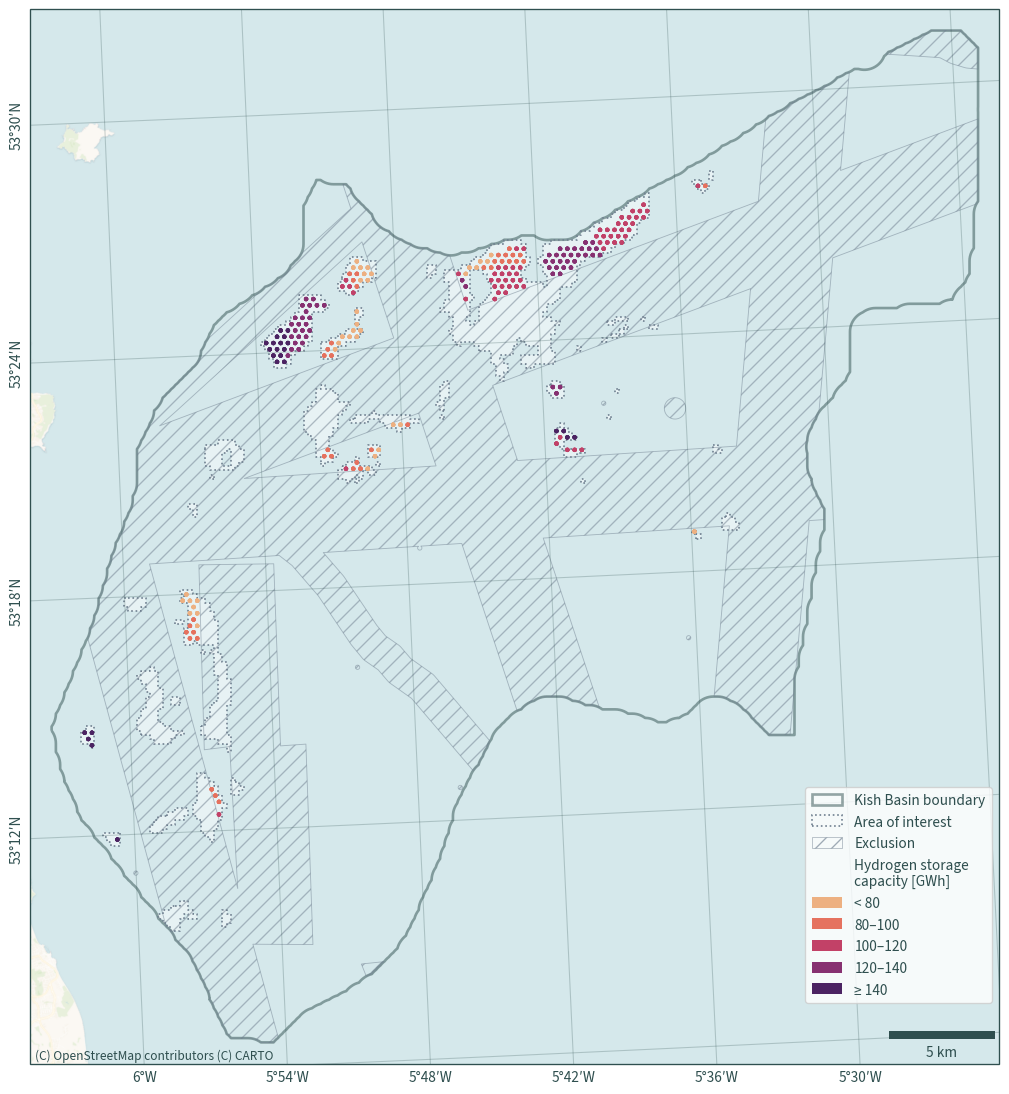

In [52]:
plot_map_alt(ds, caverns, zones, [0, 80, 100, 120, 140])

## Distribution

In [1]:
# fig, axes = plt.subplots(3, 2, figsize=(12, 8))
# for variable, label, axis in zip(
#     [
#         "cavern_depth",
#         "working_mass",
#         "p_operating_min",
#         "mass_operating_min",
#         "p_operating_max",
#         "capacity",
#     ],
#     [
#         "Top depth [m]",
#         "Working gas mass [kt]",
#         "Minimum operating pressure [MPa]",
#         "Cushion gas mass [kt]",
#         "Maximum operating pressure [MPa]",
#         "Energy storage capacity [GWh]",
#     ],
#     axes.flat,
# ):
#     if variable in ["cavern_depth", "capacity"]:
#         d1 = caverns_pot_all[[variable]]
#         d2 = caverns[[variable]]
#     else:
#         d1 = caverns_pot_all[[variable]] / 1e6
#         d2 = caverns[[variable]] / 1e6
#     sns.boxplot(
#         pd.concat(
#             [d1.set_axis(["all"], axis=1), d2.set_axis(["optimal"], axis=1)]
#         )
#         .melt()
#         .dropna(),
#         x="value",
#         hue="variable",
#         palette="flare_r",
#         linecolor="black",
#         linewidth=1.1,
#         gap=0.3,
#         width=0.55,
#         flierprops={"markeredgecolor": "grey", "alpha": 0.5},
#         ax=axis,
#         legend=False,
#     )
#     axis.set_xlabel(label)
#     axis.tick_params(axis="y", left=False)
#     if variable == "cavern_depth":
#         axis.get_xaxis().set_major_formatter(
#             ticker.FuncFormatter(lambda x, p: format(int(x), ","))
#         )

# legend_handles = [
#     # mpatches.Patch(label="Cavern top depth [m]", visible=False),
#     mpatches.Patch(
#         facecolor=sns.color_palette("flare_r", 2)[0],
#         # label="500–2,000",
#         label="HYSS",
#         edgecolor="black",
#     ),
#     mpatches.Patch(
#         facecolor=sns.color_palette("flare_r", 2)[1],
#         # label="1,000–1,500",
#         label="Hystories",
#         edgecolor="black",
#     ),
# ]
# plt.legend(loc="upper right", handles=legend_handles, fontsize=11.5)
# sns.despine()
# plt.tight_layout()
# plt.show()